
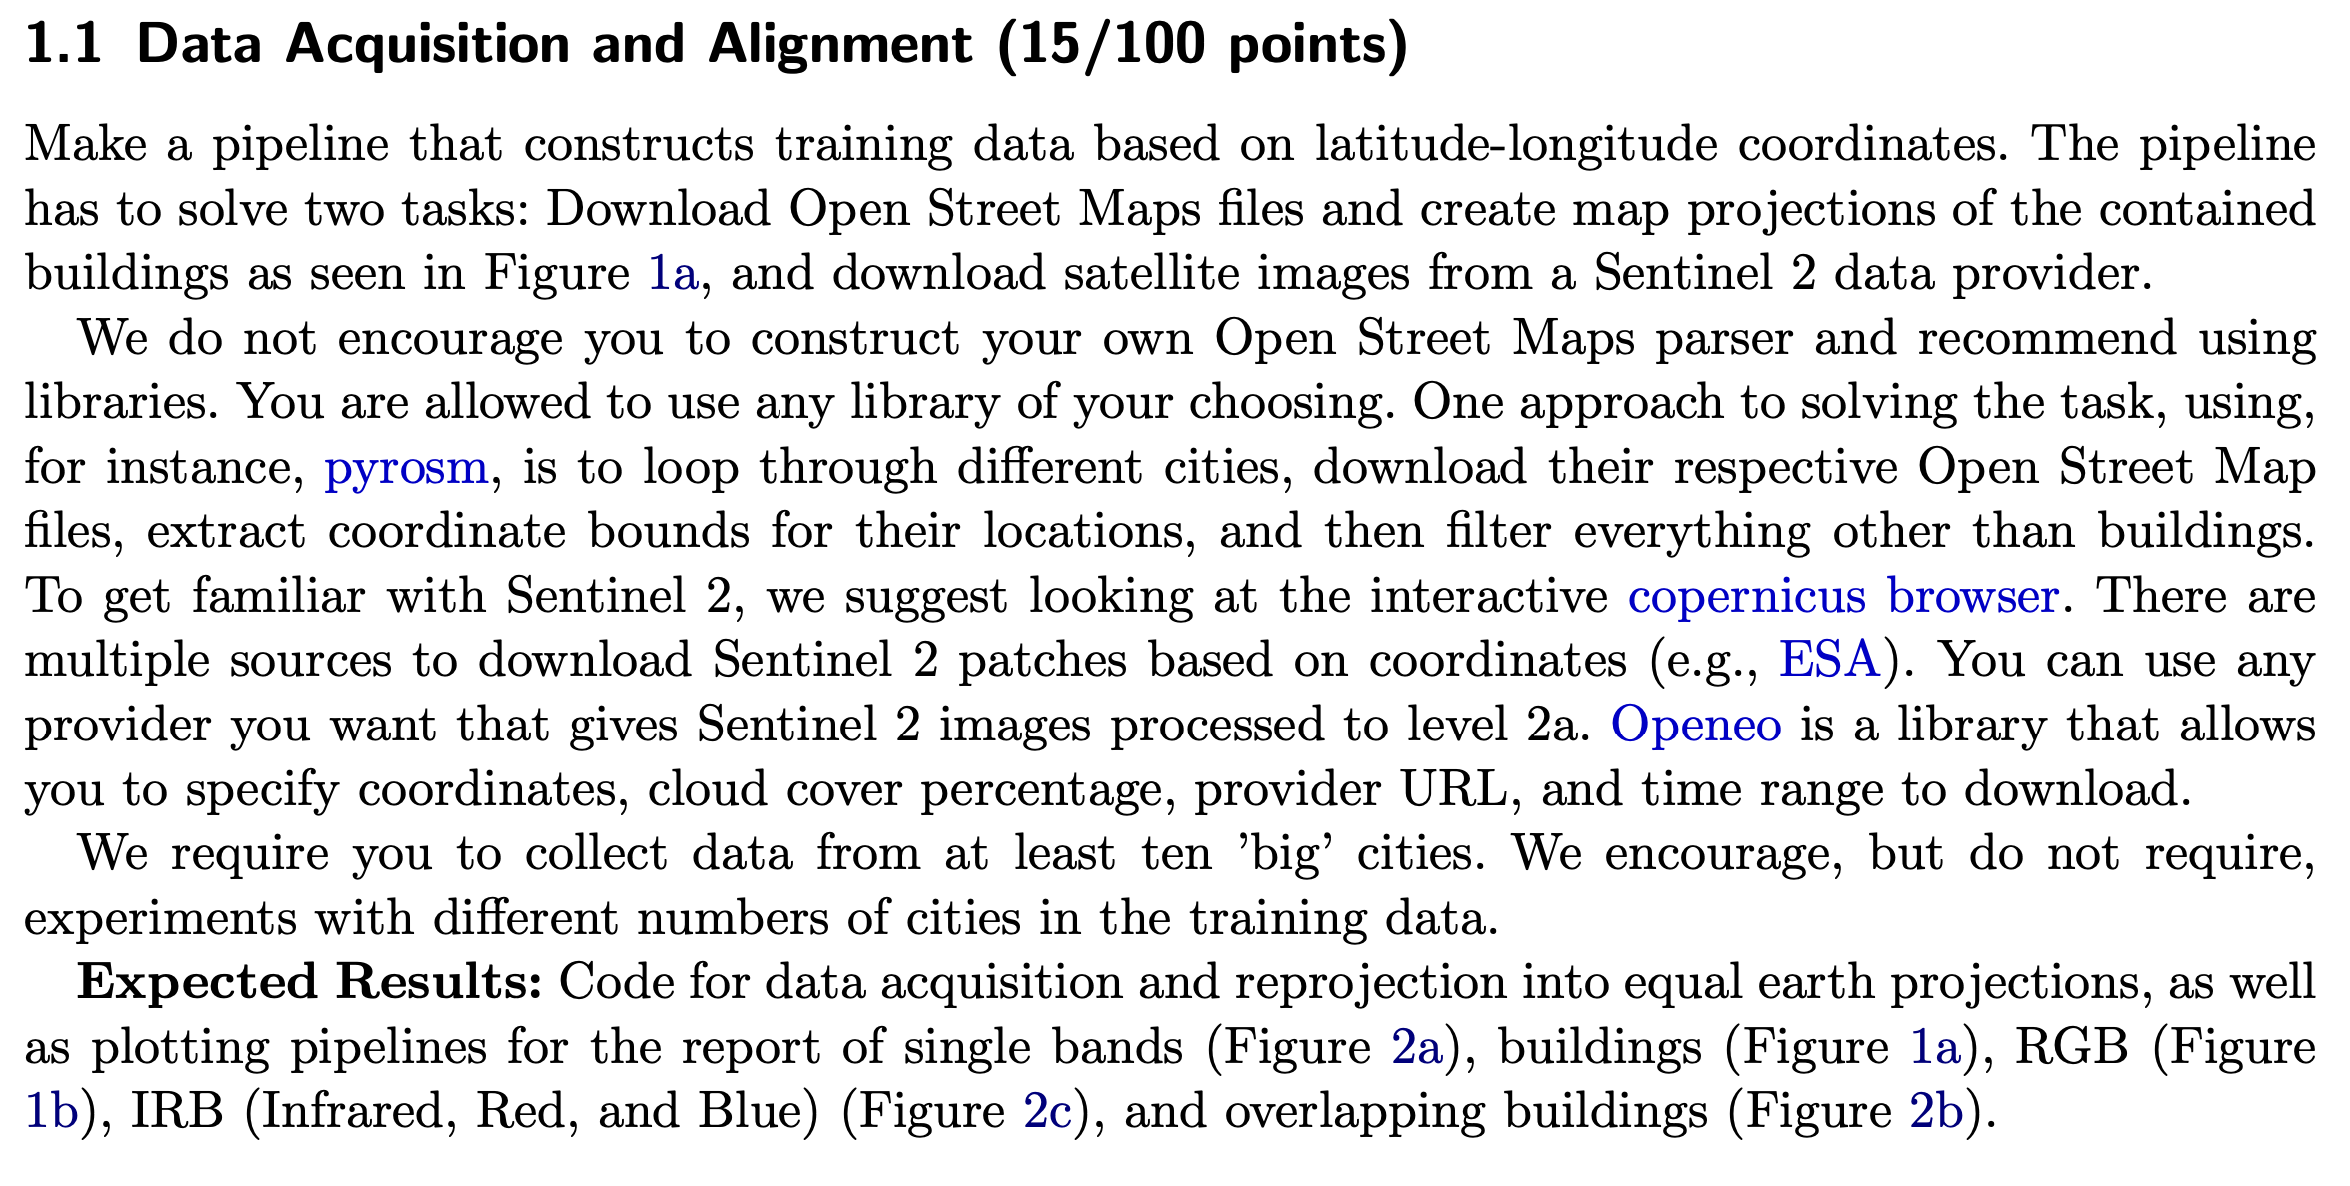

**1. Data acquisition: Download the Open streetmaps files.**

we could use pyrosm

In [10]:
import pyrosm
from io import BytesIO
import openeo
import os

import xarray
import matplotlib.pyplot as plt
import numpy as np
import random
import tempfile
import io

from pathlib import Path
from PIL import Image

from rasterio.features import rasterize

import albumentations as A
from IPython.display import display
import cv2
import sklearn.feature_extraction.image
from skimage import exposure

In [11]:
# Prepare local directories and file paths
resource_path = Path("ressources/")
resource_path.mkdir(parents=True, exist_ok=True)

osm_data_fp = resource_path / "osm_maps/"
osm_data_fp.mkdir(parents=True, exist_ok=True)

sattelite_images = resource_path / "sattelite_images/"
sattelite_images.mkdir(parents=True, exist_ok=True)

dev_mode_osm_fp = osm_data_fp / "Berlin.osm.pbf"

dev_sat_img_fp = sattelite_images / "composite_sattelite_image.nc"

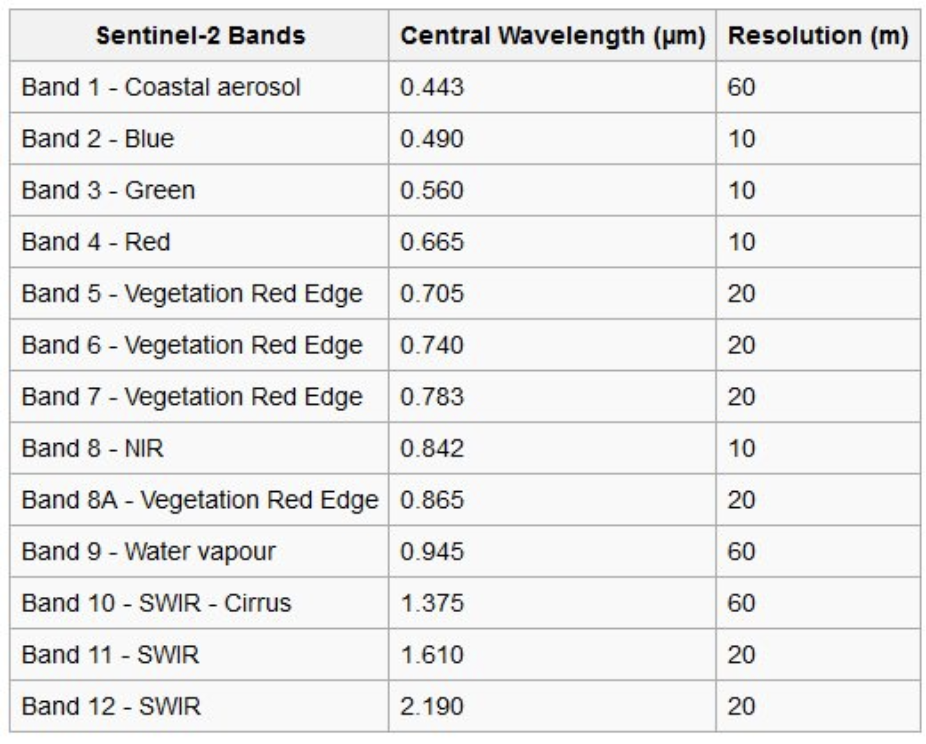

In [12]:
class Config:
    # Sattelite Related
    sentinel_2_connection_id="SENTINEL2_L2A" # Sentinel data we are dealing with
    rgb_bands = ["B04", "B03", "B02"] # Bands we are working with
    irb_bands = ["B08", "B04", "B02"]
    all_bands = ["B08","B04", "B03", "B02", "SCL"]
    
    # OSM Related
    MIN_NUMBER_OF_CITIES = 1
    HANDPICKED_CITY_COORDS = [
    [-0.224136,51.425376,0.023057,51.547662],
    [37.502643,55.692206,37.737476,55.814364],
    [28.878773,40.982672,29.075326,41.078498],
    [2.250884,48.815576,2.428039,48.90637],
    [-3.795446,40.361223,-3.605588,40.48302],
    [-2.357444,53.420581,-2.140121,53.540919],
    [2.052497,41.317035,2.228355,41.467914],
    [12.459183,55.644274,12.637024,55.724790],
    [9.902096,53.515476,10.081997,53.605835],
    [20.910186,52.175346,21.097983,52.270619]
    ]
    city_coords = HANDPICKED_CITY_COORDS # A single city for development purposes

    # Feel free to add cities to this list.
    HANDPICKED_CITIES = ["London", "Moscow", "Istanbul", "Paris", "Madrid", "Manchester",
              "Barcelona", "Copenhagen", "Hamburg", "Warsaw"]
    # TODO change back to all cities
    cities = HANDPICKED_CITIES # just using the first one for development purposes. At the end we will use all cities.
    fps = []
    
    # Training Related
    patch_size = 32
    channel_amount = 3 # TODO shouldn't this be 4?
    
    # Coordinate related W, S, E, N (min lng, min lat, max lng, max lat)
    height = 1024 # Resolution in the y direction
    width = 1024 # Resolution in the x direction
    accuracy_test_coordinates = [13.294333, 52.454927, 13.500205, 52.574409] # Berlin test data coordinates
        
config = Config()

In [13]:
def check_if_file_already_exists(fp):
    if os.path.isfile(fp):
        fp = str(fp)
        return fp
    else:
        return False

In [14]:
expected_shape = (config.patch_size, config.patch_size, config.channel_amount)

def check_np_image_size(img: np.ndarray) -> None:
    assert img.shape == expected_shape

In [15]:
# Function to download the OSM data and return the filepath
def get_city_data(city_name: str):

    # If the file exists in ressources no need to download it again.
    osm_city_local_file_path = osm_data_fp / str(city_name + ".osm.pbf")

    fp = check_if_file_already_exists(fp = osm_city_local_file_path)
    # only downloading if the file doesn't already exist in backend
    if not fp:
        fp = pyrosm.get_data(city_name, directory=osm_data_fp)

    return fp

In [16]:
# Lets make sure we have all the files for the cities we are working with
# Download does take a little while
config.fps = []
for city in config.HANDPICKED_CITIES:
    print("downloading city data: ", city)
    config.fps.append(get_city_data(city))

print("config.fps: ", config.fps)

downloading city data:  London
downloading city data:  Moscow
downloading city data:  Istanbul
downloading city data:  Paris
downloading city data:  Madrid
downloading city data:  Manchester
downloading city data:  Barcelona
downloading city data:  Copenhagen
downloading city data:  Hamburg
downloading city data:  Warsaw
config.fps:  ['ressources/osm_maps/London.osm.pbf', 'ressources/osm_maps/Moscow.osm.pbf', 'ressources/osm_maps/Istanbul.osm.pbf', 'ressources/osm_maps/Paris.osm.pbf', 'ressources/osm_maps/Madrid.osm.pbf', 'ressources/osm_maps/Manchester.osm.pbf', 'ressources/osm_maps/Barcelona.osm.pbf', 'ressources/osm_maps/Copenhagen.osm.pbf', 'ressources/osm_maps/Hamburg.osm.pbf', 'ressources/osm_maps/Warsaw.osm.pbf']


In [17]:
# Function to get building data of our cities according to our new adjusted bounding box
def get_buildings(city_data_fp,bounding_box):
    osm = pyrosm.OSM(city_data_fp, bounding_box)
    return osm.get_buildings().to_crs(4326)

# Function used for plotting and saving things in a buffer for development
def get_buildings_buffer(city_data_fp, bounding_box):
    print("extracting buildings. This can take up to a minute or two. Be patient")
    buildings = get_buildings(city_data_fp,bounding_box)
    fig = plt.figure(frameon=False)
    buildings.plot()
    plt.axis('off')

    # Save to in-memory buffer
    file_buffer = BytesIO()

    # TODO what about the amount of pixels? image size? Check when we have the Neural Network.
    fig.savefig(file_buffer, format='png', bbox_inches='tight',transparent=True, pad_inches=0)

    return file_buffer

In order to be able to manipulate the image we need to be able to rasterize it first

In [18]:
# Uses a lot of memory depending on the resolution (height/width)
def rasterize_osm(fp, coords, height=config.height, width=config.width):
    print("this can take up to a minute or two")
    buildings = get_buildings(fp,coords)
    xres = (coords[2] - coords[0]) / width
    yres = (coords[3] - coords[1]) / height
    # Affine transformation
    #| x' |   | a  b  c | | x |
    #| y' | = | d  e  f | | y |
    #| 1  |   | 0  0  1 | | 1 |
    return rasterize(shapes=buildings.geometry,
                     out_shape=(height, width),
                     transform=(xres, 0, coords[0], 0, -yres, coords[3]))
def plot_raster(img):
    fig = plt.figure(figsize=(8,5))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

extracting buildings. This can take up to a minute or two. Be patient


<Figure size 640x480 with 0 Axes>

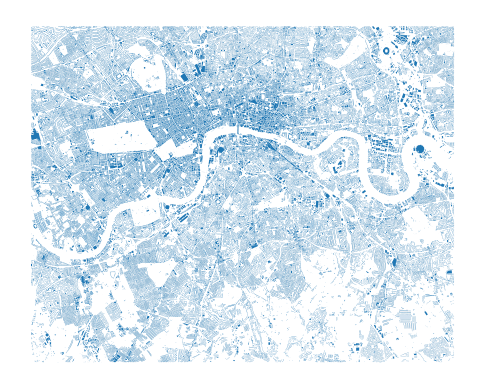

In [19]:
building_buffer = get_buildings_buffer(config.fps[0], config.city_coords[0])
image = Image.open(io.BytesIO(building_buffer.getvalue()))
building_buffer.close()

this can take up to a minute or two


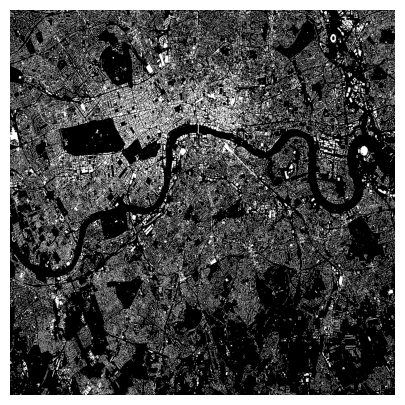

In [20]:
plot_raster(rasterize_osm(config.fps[0], config.city_coords[0]))

In [21]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")

# You will have to click on the displayed url in the output once first time you run the notebook
connection.authenticate_oidc()

INFO:openeo.config:Loaded openEO client config from sources: []
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_token', 'refresh_token']
INFO:openeo.rest.auth.config:Storing refresh token for issuer 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE' (client 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')


Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [22]:
# Turning bounding box into WSEN dict
def get_spatial_extend(bounding_box):
    spatial_extend = {
    "west": bounding_box[0], 
    "south": bounding_box[1], 
    "east": bounding_box[2], 
    "north": bounding_box[3],
    "crs": "EPSG:4326",
    }
    return spatial_extend

In [23]:
def get_masked_data(city_index: int, coords, bands, start_date = "2023-04-01", end_date = "2023-08-30"):
    city = config.cities[city_index] + "_masked"
    sattelite_img_fp = sattelite_images / str(city + ".nc")
    
    if not check_if_file_already_exists(sattelite_img_fp):
        # Prepare the Query (Summer/Spring months, Long periods are preferred, low cloud coverage)
        s2_cube = connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date, end_date),
            spatial_extent=get_spatial_extend(coords),
            bands=config.all_bands,
            max_cloud_cover=30,
        )
        # Mark which band we are using for masking
        scl_band = s2_cube.band("SCL")
        # Mask which pixel values we want replaced
        cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
        # Resample the resolution (because SCL is 20m res, not 10, it may create artifacts if we dont do this)
        cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)
        # Mask our query and get the mean values
        composite_masked = s2_cube.mask(cloud_mask).mean_time()

        print("saving a masked version of ", city, " locally so that we don't have to redownload the sattelite data again.")
        composite_masked.download(outputfile=sattelite_img_fp)

    ds = xarray.load_dataset(sattelite_img_fp)
    # Convert xarray DataSet to a (bands, x, y) DataArray
    return ds[bands+["SCL"]].to_array(dim="bands")

In [24]:
# TODO make approach 2 use locally saved data as well?
def get_least_cloudy_data(city_index: int, coords, bands, start_date = "2023-08-01", end_date = "2023-09-30"):
    city = config.cities[city_index] + "_temporal"
    sattelite_img_fp = sattelite_images / str(city + ".nc")
    
    if not check_if_file_already_exists(sattelite_img_fp):
        # Prepare the Query (Summer/Spring months, short periods are acceptable , any cloud coverage)
        s2_cube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=(start_date, end_date),
        spatial_extent=get_spatial_extend(coords),
        bands=config.all_bands,
        max_cloud_cover=50,
        )

        print("saving a temporal version of ", city, " locally so that we don't have to redownload the sattelite data again.")
        s2_cube.download(outputfile=sattelite_img_fp)
        print("download finished")

    ds = xarray.load_dataset(sattelite_img_fp)
    # Convert to Data array
    time_data = ds[bands+["SCL"]].to_array(dim="bands")
    # Variables to save least cloudy day
    min_clouds = float('inf')
    min_index = 0

    for i,inst in enumerate(time_data[3]):
        # Count SCL classes
        indices,counts = np.unique(inst.data,return_counts=True)

        curr = dict(zip(indices, counts))
        # Count cloudy pixels
        cld_small = curr.get(8)
        cld_big = curr.get(9)
        cld_shadow = curr.get(3)
        # Sum up cloudy pixels
        curr_clouds = cld_small if cld_small else 0 + cld_big if cld_big else 0 + cld_shadow if cld_shadow else 0
        # Save minimum cloudyness
        if(curr_clouds<min_clouds):
            min_clouds=curr_clouds
            min_index=i
        # if its not cloudy we immediately take it
        if(min_clouds==0): break
    # Save least cloudy day
    return time_data[:,i,...]

In [25]:
def get_spatial_data(city_index : int, coords, bands, approach=True, save_spatial_data = False):
    if approach:
        return get_masked_data(city_index, coords,bands)
    else:
        return get_least_cloudy_data(city_index, coords,bands)

In [26]:
def get_spatial_image(data, bands):
    # handle single band images
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
    plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
    if len(bands) == 1:
        data[0].plot.imshow(vmin=0, vmax=2000, ax=ax, cmap='Greys',  interpolation='bilinear')
    else:
        data[0:3].plot.imshow(vmin=0, vmax=2000, ax=ax)

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)

    plt.close(fig)
    # data.plot.imshow(vmin=0, vmax=2000)

    return buf

In [27]:
def display_sattelite_image(data, bands):
    print("generating spatial image")
    satt_image_buf = get_spatial_image(data, bands = bands)
    sattelite_image = Image.open(io.BytesIO(satt_image_buf.getvalue()))
    display(sattelite_image)
    satt_image_buf.close()

### RGB SATTELITE IMAGE

generating spatial image


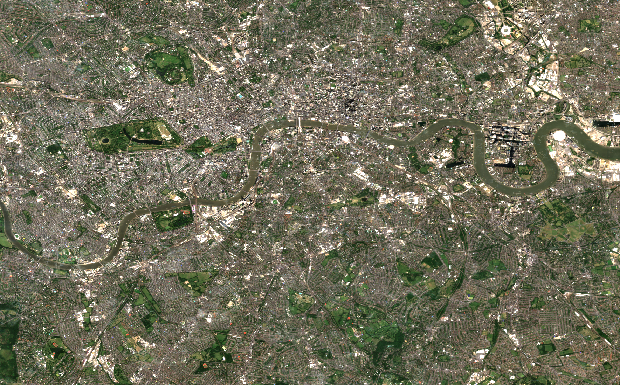

In [28]:
display_sattelite_image(get_spatial_data(0, config.city_coords[0],config.rgb_bands),bands=config.rgb_bands)

### IRB SATTELITE IMAGE

generating spatial image


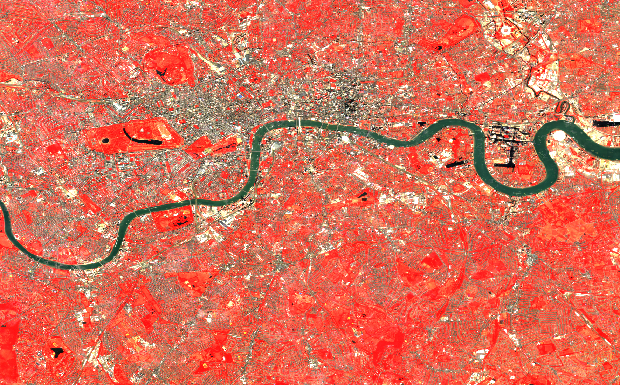

In [29]:
display_sattelite_image(get_spatial_data(0, config.city_coords[0], config.irb_bands), bands=config.irb_bands)

### SINGLE BAND SATTELITE IMAGE

generating spatial image


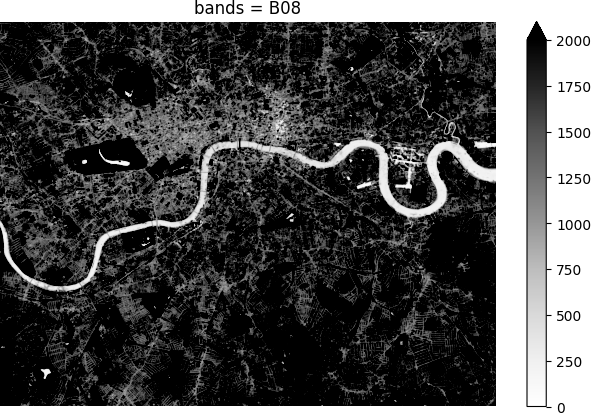

In [30]:
display_sattelite_image(get_spatial_data(0, config.city_coords[0], bands=["B08"]), bands=["B08"])

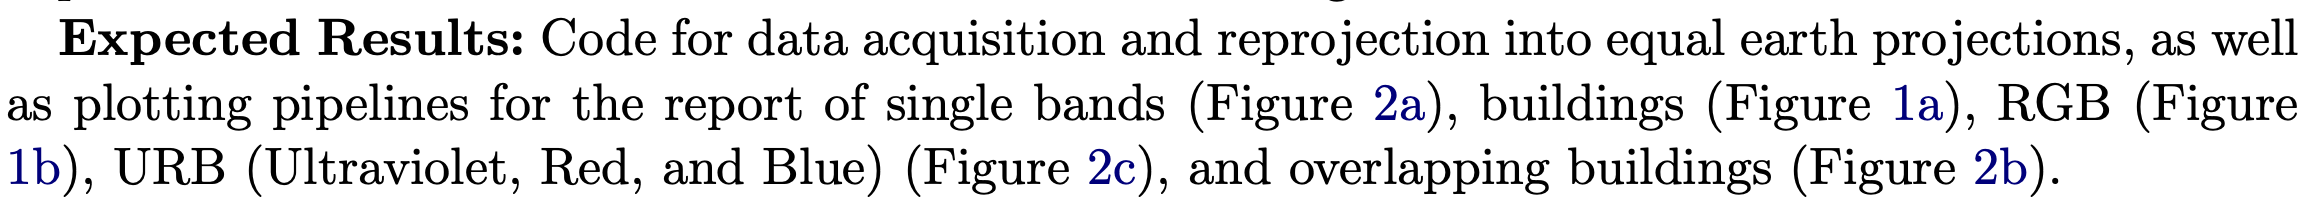

## 1.2 Data Preparation
- Training (Sattelite) images from Task 1.1 are given in an xarray Dataset of shape [Bands, Height, Width] per image, but also associated with it are variable spatial coordinates.
    - Bands dictating which bands we used
    - X dictating the spatial longitude coordinates of our PixelX
    - Y dictating the spatial latitude coordinates of our PixelY
- Osm data are given as a 2d raster numpy array (pixel_x, pixel_y)

#### Task:
1. Given the pipeline from Task 1.1, prepare the large images for training by slicing out tensors containing smaller training images of equal width and height, for instance, 32, 64, or 128 pixels

2.  include in the pipeline a simple cloud-cover classifier and remove all patches containing clouds.

3. Divide the data into train/validation/test sets of similar data distributions (e.g., label distribution and potentially other properties such as visual similarity or data provenance

In [31]:
# Conversion from xarray to NParray does not properly display the image (xarray luminance vs nparray RGB)
# Normalization on its own does not work due to outliers
# This is done implicitly in dataArray.plot.imshow but not in npArr.imshow
def xarr_to_np(data):
    # reorganizing dimensions
    new_data = np.zeros((data.shape[1],data.shape[2],data.shape[0]))
    new_data[:,:,0] = data[0,:,:]
    new_data[:,:,1] = data[1,:,:]
    new_data[:,:,2] = data[2,:,:]
    new_data[:,:,3] = data[3,:,:]
    
    # Removal of negative values
    min_v = new_data.min()
    new_data += abs(min_v) if min_v<0 else 0 
    # Removal of outlier values
    p_2, p_98 = np.percentile(new_data, (2, 98))
    new_data = np.clip(new_data, p_2, p_98)
    # Normalization according to our new min and max
    new_data = (new_data - p_2) / (p_98 - p_2)

    return new_data

def plot_np_img(data):
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
    plt.imshow(data[:,:,0:3])

In [32]:
# We embedd another "band" to our sattelite data that indicates per pixel if there is a building or not
def combine_sattelite_with_osm_buildings(s2,osm,color=2):
    osm = osm[:,:,None]
    rev_osm = (-1*osm)
    broad_osm = np.concatenate((osm,rev_osm,rev_osm,np.zeros(osm.shape)), axis=2).squeeze()
    broad_osm[[color,0]] = broad_osm[[0,color]]
    return np.clip((s2 + broad_osm),0,1)

In [33]:
def patch_arr(data, res=config.patch_size, mode="Grid", max_patch=1000):
    if mode=="Grid":
        
        # Generate patches from a regular grid
        min_w = data.shape[0]
        min_h = data.shape[1]
        # If the length dimension does not match a regular subdivision of grids, clip the start of it
        if(min_w%res!=0):
            min_w -= int(min_w - np.floor(min_w/res)*res)
        # If the width dimension does not match a regular subdivision of grids, clip the start of it
        if(min_h%res!=0):
            min_h -= int(min_h - np.floor(min_h/res)*res)
        data = data[:min_w,:min_h,:]

        # Otherwise if we are dealing with numpy arrays
        return data.reshape((min_w//res,
                             res,
                             min_h//res,
                             res,-1)).transpose(0,2,1,3,4).reshape(-1,res,res,data.shape[2])
    
    if mode=="Random":
        # Randomly crop out patches from the image (Only supported for np arrays)
        return sklearn.feature_extraction.image.extract_patches_2d(data,
                                                                   (res,res),max_patches=max_patch, random_state=0)

In [34]:
# Function that takes in a patch and returns if that patch is cloudy according to a precentage.
def detect_cloud_patch(img,precent):
    p = (np.where((img==1) + (img==2) + (img==8) + (img==9))[0].shape[0] / (img.shape[0]**2))
    return p>precent

# Removed cloudy patches from our dataArray
def remove_clouds(data,precent=0.02):
    n=data.shape[0]
    for i in range(n):
        if(i==data.shape[0]): break
        if detect_cloud_patch(data[i,:,:,3],precent):
            data = np.delete(data,i,axis=0)
    return (data[:,:,:,0:3], data.shape[0])

In [35]:
# Visual Example over 1 city for debugging

# temp_coords = config.city_coords[0]
# temp_fp = config.fps[0]

# # Raw Data
# s2 = get_spatial_data(0, temp_coords, config.rgb_bands)
# osm = rasterize_osm(temp_fp, temp_coords, example_s2.shape[1],example_s2.shape[2])
# # Plot
# print(s2.shape, osm.shape)
# display_sattelite_image(s2, config.rgb_bands)
# plot_raster(osm)

# fig = plt.figure(figsize=(15, 15), layout='tight')
# # Convert to numpy
# s2_np = xarr_to_np(s2)
# # Plot
# fig.add_subplot(2, 2, 1)
# plot_np_img(s2_np)

# # Overlap buildings (Does this need to be grayscale?)
# combined = combine_sattelite_with_osm_buildings(s2_np,osm)
# # Plot
# fig.add_subplot(2, 2, 2)
# plot_np_img(combined)

# # Slice the combined version and the raw version
# sliced_s2 = patch_arr(example_s2_np,res=64)
# sliced_combined = patch_arr(combined,res=64)
# # Plot
# fig.add_subplot(2, 2, 3)
# plot_np_img(sliced_s2[0])
# fig.add_subplot(2, 2, 4)
# plot_np_img(sliced_combined[0])

# # Remove cloudy patches
# cloudless_s2,__ = cloudless_img(sliced_s2)
# cloudless_combined,__ = cloudless_img(sliced_combined)
# print(cloudless_s2.shape)

In [36]:
# indicates where each cities samples start index wise
sample_indices = []
count = 0

# Iterate over citites
for city_index, (c,f) in enumerate(zip(config.city_coords,config.fps)):
    # Name the city
    name = f.split('/')[-1].split('.')[0]
    print("Processing data for", name)
    # Fetching data
    s2 = get_spatial_data(city_index, c, config.rgb_bands)
    osm = rasterize_osm(f, c, s2.shape[1],s2.shape[2])
    
    # Convert to numpy for ease of use
    city_data = xarr_to_np(s2)
    
    # Highlighting building pixels to get the targets
    city_target = combine_sattelite_with_osm_buildings(city_data,osm)
    
    # Patching the data into many
    sliced_city_data = patch_arr(city_data, mode="Grid")
    print("Created ", sliced_city_data.shape[0], " patches from this image")
    sliced_city_targets = patch_arr(city_target, mode="Grid")
    
    # First iteration initilaize X and y 
    if (city_index==0):
        X,size = remove_clouds(sliced_city_data)
        print(sliced_city_targets.shape)
        y,__ = remove_clouds(sliced_city_targets)
        
        print("Removed ", sliced_city_data.shape[0]-size, " potentially cloudy patches")
        sample_indices.append(count)
        count+=size
        continue
    
    # Remove clouds from our patches
    cloudless_x,size = remove_clouds(sliced_city_data)
    print("Removed ", sliced_city_data.shape[0]-size, " potentially cloudy patches")
    cloudless_y,__ = remove_clouds(sliced_city_targets)
    
    # Append them to the final array
    X = np.concatenate((X,cloudless_x),axis=0)
    y = np.concatenate((y,cloudless_y),axis=0)
    
    # Update the indices
    sample_indices.append(count)
    count+=size
sample_indices.append(count)

Processing data for London
this can take up to a minute or two
Created  2420  patches from this image
(2420, 32, 32, 4)
Removed  0  potentially cloudy patches
Processing data for Moscow
this can take up to a minute or two
Created  1978  patches from this image
Removed  0  potentially cloudy patches
Processing data for Istanbul
this can take up to a minute or two
Created  1768  patches from this image
Removed  0  potentially cloudy patches
Processing data for Paris
this can take up to a minute or two
Created  1240  patches from this image
Removed  0  potentially cloudy patches
Processing data for Madrid
this can take up to a minute or two
Created  2100  patches from this image
Removed  0  potentially cloudy patches
Processing data for Manchester
this can take up to a minute or two
Created  1890  patches from this image
Removed  0  potentially cloudy patches
Processing data for Barcelona
this can take up to a minute or two
Created  2392  patches from this image
Removed  0  potentially cl

In [37]:
def train_val_test_split(X, y, indices, val=0.1, test=0.2):
    test_indices = []
    val_indices = []
    ratio = val/(test+val)
    # Generating random indices of validation and test per city
    # we dont want one city to dominate Train/Test/Val subset
    for i in range(1,len(indices)):
        # Total number per distribution per city
        total = indices[i]-indices[i-1]
        val_n = int(val*total)
        test_n = int(test*total)
        total = total - val_n - val_n
        # Sample indices randomly
        total_indices = random.sample(range(indices[i-1],indices[i]),val_n+test_n)
        split = int(ratio*(val_n+test_n))
        # Append the indices
        val_indices = np.concatenate((val_indices,total_indices[:split]))
        test_indices = np.concatenate((test_indices,total_indices[split:]))
    #turn into np array
    val_indices = np.array(val_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)
    # Take those indices from our array
    val_X = np.take(X,val_indices,axis=0)
    val_y = np.take(y,val_indices,axis=0)
    
    test_X = np.take(X,test_indices,axis=0)
    test_y = np.take(y,test_indices,axis=0)
    # Remove them from the original array
    remove = np.concatenate((val_indices,test_indices))
    train_X = np.delete(X,remove,axis=0)
    train_y = np.delete(y,remove,axis=0)
                            
    return (train_X, train_y, val_X, val_y, test_X, test_y)

In [38]:
train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X,y,sample_indices)
print(X.shape, y.shape)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(17270, 32, 32, 3) (17270, 32, 32, 3)
(12094, 32, 32, 3) (12094, 32, 32, 3) (1724, 32, 32, 3) (1724, 32, 32, 3) (3452, 32, 32, 3) (3452, 32, 32, 3)


Expected Results: Code for data preparation of disjoint train, validation, and test data with
similar distributions of statistics. The report should justify the chosen selection procedure and how it
preserves the similarity of specific properties

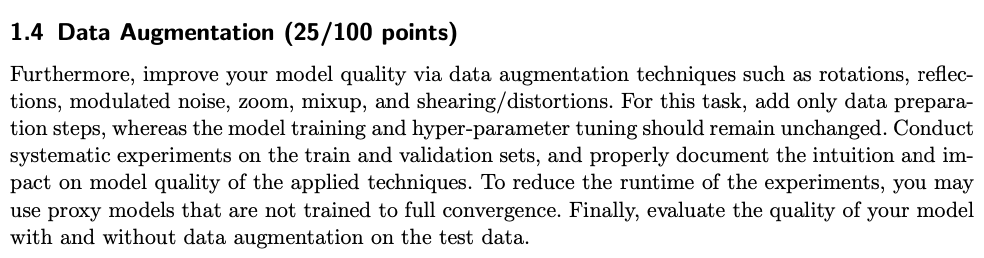

I will now write functions which provide the data augmentation functionality. Doing this before 1.3, because we can probably train with and without the augmented data immediately if we include the data augmentation functions into the pipeline.

Let's start by defining both the geometric and the other transformations

In [39]:
geometric_transformations = A.Compose([
    A.Rotate(limit=45, border_mode=cv2.BORDER_REFLECT, value=(0, 0, 0), p=1.0),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
],
additional_targets={'osm_img': 'image'})

other_transformations = A.Compose([
    # random noise
    A.RandomRain(slant_lower = 0, slant_upper=0, brightness_coefficient=1.0, drop_length=2, drop_width=2, drop_color = (0, 0, 0), blur_value=1, rain_type = None,p=1),
    A.RandomBrightnessContrast(p=0.2),
])

The transformation needs to take as input two images, the sattelite one, and the openstreetmap image.

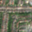

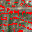

In [40]:
example_satt_image, example_osm_target = train_X[0], train_y[0]
display(Image.fromarray((example_satt_image * 255).astype(np.uint8)))
display(Image.fromarray((example_osm_target * 255).astype(np.uint8)))

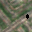

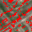

In [41]:
# TODO augment the entire training dataset!
def get_data_augmentation(sattelite_img, osm_img):
    for img in [sattelite_img, osm_img]:
        check_np_image_size(img)
    
    sattelite_img = (sattelite_img * 255).astype(np.uint8)
    osm_img = (osm_img * 255).astype(np.uint8)
        
    
    # let's first apply the geometric augmentations
    transformed_images = geometric_transformations(image = sattelite_img, osm_img = osm_img)
    geom_sattelite_img, augmented_osm_img = transformed_images["image"], transformed_images["osm_img"]
    
    augmented_sattelite_img = other_transformations(image=geom_sattelite_img)["image"]
    
    augmented_sattelite_img = (augmented_sattelite_img / 255).astype(np.float32)
    augmented_osm_img = (augmented_osm_img / 255).astype(np.float32)

    for img in [augmented_sattelite_img, augmented_osm_img]:
        check_np_image_size(img)

    return augmented_sattelite_img, augmented_osm_img

augmented_sattelite_img, augmented_osm_img = get_data_augmentation(sattelite_img=example_satt_image, osm_img = example_osm_target)

for img in [augmented_sattelite_img, augmented_osm_img]:
    display(Image.fromarray((img * 255).astype(np.uint8)))